In [235]:
from audioFunctions import *
from binaryFunctions import *
from qam import *
from sequenceGenerators import *
from receiver import *
from to_import import *

In [236]:
def str_to_bytearray(string_data):
    new_data = []
    for i in range(0, len(string_data), 8):
        new_data.append(string_data[i:i+8])  

    int_data = [] 
    for i in new_data:
        int_data.append(int(i,2))

    return bytearray(int_data)

In [237]:
with open('Data_Files/a7r56tu_knownseq.csv', 'r') as file:
    raw = file.read().replace('\n', ',').split(',')

known = []
for value in raw:
    try:
        v = float(value)
        if v == 0:
            symbol = cmath.exp((math.pi/4) * 1j)
        elif v ==1:
            symbol = cmath.exp((3*math.pi/4) * 1j)
        elif v == 2:
            symbol = cmath.exp((5*math.pi/4) * 1j)
        else:
            symbol = cmath.exp((7*math.pi/4) * 1j)
        

        known.append(symbol)
    except:
        pass
    
known = np.array(known)

In [238]:
first1024 = known[:1024]

first_half = []
for val in first1024:
    first_half.append(val)
    first_half.append(0)
first_half.pop()

SC_fourier = np.concatenate(([0], first_half, [0], np.conjugate(first_half[::-1])))
SC_time = ifft(known_fourier).real

known_fourier = np.concatenate(([0], known, [0], np.conjugate(known[::-1])))
known_time = ifft(known_fourier).real

In [239]:
# So far this works the best at estimating the location... 
chirp_signal = Chirp(100,8000,1, volume = 100)
print(len(chirp_signal))

48000


In [240]:
y = audioDataFromFile('Data_Files/c9a71v_received.wav')

In [241]:
y_section = np.reshape(y, y.size)[0:200000]
g = np.convolve(y_section, chirp_signal[::-1], 'valid') # convoluton
i_max = np.argmax(g[:int(len(g)/2)])

In [242]:
# NOT SURE HOW TO DO SECOND PART OF SCHMIDL AND COX!!!!
'''afterchirp = i_max + len(chirp_signal)+101
window_length = 4096
y_window = y[afterchirp:afterchirp+window_length]

f_window = fft(y_window)

div = []
for i in range(4096):
    if i%2 == 1:
        div.append(f_window[i]/SC_fourier[i])

plot_y(np.unwrap(np.angle(div)))
plot_y(np.angle(div), f=1)
print(abs(f_window)[:10])
#plot_y(np.angle(f_window))

check_length = 2048-100
corr = []
for i in range(2048):
    p = np.array(y_window[i:i+check_length])
    p_dash = np.array(y_window[i+2048:i+2048+check_length])
    #print(p.shape, p_dash.shape)
    corr.append(np.dot(p, p_dash))
    #print(i)
    
plot_y(corr)

i_min = np.argmin(corr)
rng = 100
plot_y(corr[i_min - rng:i_min + rng], f=2, title="Closeup of peak +- " + str(rng) + " samples")'''
3

3

In [305]:
error = 0
y_confirm = y[i_max+ len(chirp_signal)+4096+100+error:]

shift = 100
#sliceData(time_data, timeshift, N, K, repeat)
CE_samples, CE_freq, remaining = sliceData(y_confirm, 100, 4096, 100, 100)

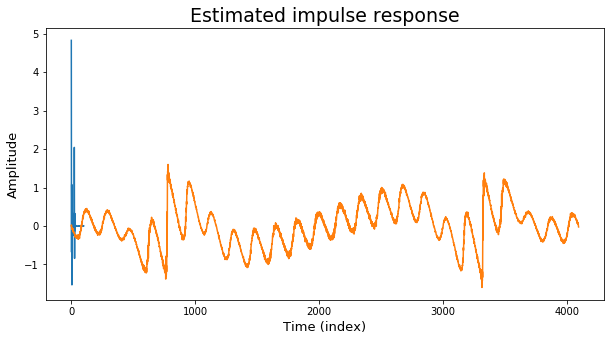

In [306]:
# getImpulseSimple(freq, known_freq, N, repeat)
impulse_simple, TF = getImpulseSimple(CE_freq, known_fourier, len(CE_freq[0]), len(CE_freq))

labelsize = 13
ticksize = 13
titlesize = 19

plot_length = 100
plt.figure(0, figsize = (10,5))
freq_x = np.linspace(0, plot_length/fs, plot_length)
x = np.linspace(0, plot_length, plot_length)

plt.plot(x, impulse_simple[0:plot_length])
plt.xlabel("Time (index)", fontsize = labelsize)
plt.ylabel("Amplitude",  fontsize = labelsize)

plt.title("Estimated impulse response", fontsize = titlesize)

plt.show
#plt.savefig("Data_Files/w2_3_impulse.pdf")
#plot_y(impulse_simple)

plot_y(np.angle(TF))

In [307]:
y_data = y_confirm[4196*100:]

2051076


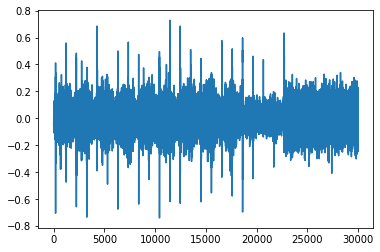

In [308]:
d = len(y_data)/4096

chunks = []
for i in range(math.floor(d)):
    chunks.append(y_data[i*4096:(i+1)*4096])

print(len(y_data))
plot_y(y_data[-120000:-90000])

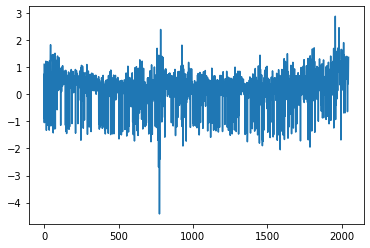

In [309]:
binary = []
freq = TF[1:2048]
for i in range(10): #len(chunks)):
    fft_data = fft(chunks[i])[1:2048]
   
    div = np.divide(fft_data, freq)
    if i == 0:
        plot_y(div.imag, f=i)
        
    
    for j in range(len(div)):
        #div = fft_data[j]/TF[j+1]
        
        bit0 = 0
        bit1 = 0
        
        if div[j].real < 0:
            bit1 = 1
        if div[j].imag < 0:
            bit0 = 1
            
        binary.append(bit0)
        binary.append(bit1)

bin_single_sting = ""
for i in range(len(binary)):
    bin_single_sting += str(binary[i])

In [310]:
# Find information about the file name and the byte length of the file
file_seperation = []
count = 0
for i in range(math.floor(len(binary)/8)):
    byte = binary[i*8:(i+1)*8]
    zero = True
    for bit in byte:
        if bit == 1:
            zero = False
            
    if zero:
        #print(byte, "zero")
        file_seperation.append(i*8)
            
        count += 1
    
    if count == 2:
        break
        
print(file_seperation)
# Extract file name and length of the file
Filename= str_to_bytearray(bin_single_sting[0:file_seperation[0]]).decode("utf-8", "replace")
print(Filename)
Length = int(str_to_bytearray(bin_single_sting[file_seperation[0]+8:file_seperation[1]]).decode())

extra_bits = len(binary) - file_seperation[1] - 8 - Length*8

raw_file = bin_single_sting[file_seperation[1] + 8 : -1*extra_bits]

print(Filename, Length, extra_bits)

[80, 136]
c9a71v.txt
c9a71v.txt 243729 -1909036


In [311]:
str_to_bytearray(bin_single_sting[:80*50]).decode("utf-8", "replace")

"c9a71v.txt\x00243729\x00GATCTTAAACATTTATTCCCCCTGCAAACATTTTCAATCATTA�ATtGTCATTTcCCCTCCAAATTAAAtTTAGCCAGAG\nG�GCacaaCITACGAKCTCTaaaAAAGGTg�TGTAAKatgtACC\\Ati|oc�O�kgCaC<��atGA'!GkGg��tagkAG��GvTt�gTb(\x05;}6�\x10�g#t\x14T�TTTAtAtTaaCTtgAA�\x0f|�t�T�<t���\x1e���oAGt�TA�aCAAAGGgagCGgtTT\nACatTOAaTTaaAgGCa�C|a�tgATGggTtgtGTaATgtttCaAaGAgCTg4TocAGc�tgaG\x14Gg�AAaTAAAaCCGT\na|TAGTGCT�cC�ogK�C)\x7ftt�g��AcaAaA�gg\x01GcOaTTCKATTaAGaGA�COIFVBAGC\x01XA\x01O\\GGAA�A�CTAa\naGVTT�tGAiAAT��TP�C<CVG\x07AT��A�IG�\x01\\CV\x03ATAAcACAGAaACAGCACTCc�QC\x01GC\x14F\x03QtT\x10AT\x01CT"